# Transfer Entropy Analysis in the Energy Sector

## Introduction

This notebook explores the directional flow of information among major energy companies using **transfer entropy (TE)**—a model-free measure that captures nonlinear dependencies beyond traditional linear methods (e.g., Granger causality).

Our analysis follows these steps:
- **Data Preprocessing:**  
  Daily stock log-returns are normalized and tested for stationarity (via ADF tests) to ensure comparability.
  
- **TE Estimation:**  
  We compute TE with two methods:  
  1. A **discrete binning estimator** (fixed number of bins)  
  2. A **$k$-nearest neighbors (kNN) estimator** (using a one-day lag, with $k=5$)
  
- **Significance Testing:**  
  Surrogate data tests (using block shuffling) generate a null distribution, allowing us to compute a p-value for each TE estimate.

- **Results Analysis:**  
  We compare TE estimates (e.g., between XOM and CVX), assess parameter sensitivity, and contrast findings with a linear Granger causality test.

- **Temporal Dynamics:**  
  Rolling-window TE analysis reveals how information flow evolves over time, particularly in response to major market events.

- **Visualization:**  
  The strongest directional influences are identified and visualized using bar charts and network graphs.

Significant TE values (p < 0.05) are marked with an asterisk (*). This streamlined approach provides insights into which companies drive sector dynamics and how external events influence information transfer.


In [2]:
# Cell 1
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the project root to sys.path so that we can import from the src folder
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

# Import TE estimator functions from the src folder
from src.te_estimators import discrete_te, knn_te

# Set a plotting style
sns.set(style='whitegrid')


In [3]:
# Cell 2
# Load processed datasets
df_close = pd.read_csv('../data/processed/energy_close_processed.csv', parse_dates=['Date'], index_col='Date')
df_marketcap = pd.read_csv('../data/processed/energy_market_cap_processed.csv', parse_dates=['date'], index_col='date')
df_volume = pd.read_csv('../data/processed/energy_volume_processed.csv', parse_dates=['Date'], index_col='Date')

# Display the first few rows of each to verify
print("Processed Closing Prices:")
print(df_close.head())
print("\nProcessed Market Cap:")
print(df_marketcap.head())
print("\nProcessed Volume:")
print(df_volume.head())


Processed Closing Prices:
                 XOM       CVX       COP       SLB       EOG       MPC  \
Date                                                                     
2021-05-19 -1.204243 -1.473522 -1.225917 -1.130526 -1.078898 -0.519842   
2021-05-20 -0.129805  0.162851 -0.156984 -0.255399 -0.026154  0.034435   
2021-05-21  0.053356  0.260711  0.165444  0.183002 -0.217437 -0.089308   
2021-05-24  0.557659  0.707396  0.299492 -0.277282  0.013927  0.659189   
2021-05-25 -1.136589 -0.861533 -0.895200 -0.507740 -0.673930 -0.479760   

                 PSX       VLO       WMB       BKR  ...      SBOW       REI  \
Date                                                ...                       
2021-05-19 -0.496063 -1.066905 -0.640505 -0.885677  ... -1.021489 -0.574884   
2021-05-20 -0.311468 -0.153131  0.611886  0.239156  ... -0.719157 -0.772287   
2021-05-21 -0.399902  0.078585  0.077427  0.222463  ...  0.712642  0.199326   
2021-05-24  0.567484  0.491440  0.219365 -0.601457  ...  0.6

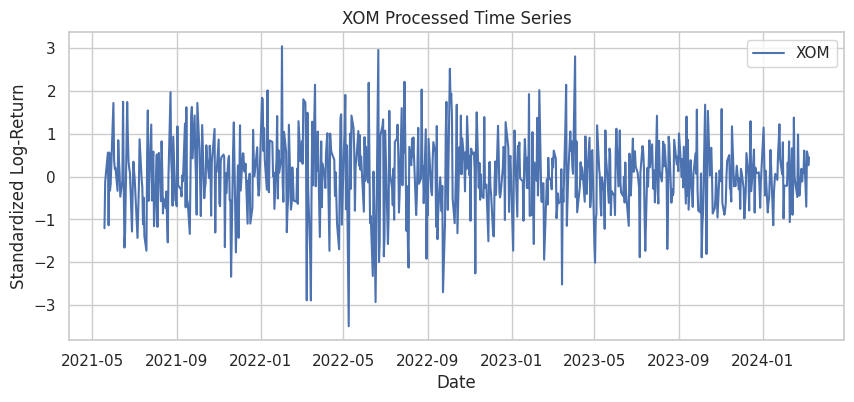

In [4]:
# Cell 3
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style='whitegrid')

# Plot the processed 'XOM' time series.
plt.figure(figsize=(10, 4))
plt.plot(df_close.index, df_close['XOM'], label='XOM')
plt.xlabel('Date')
plt.ylabel('Standardized Log-Return')
plt.title('XOM Processed Time Series')
plt.legend()

# Define the save path: since the notebook is in "notebooks", go up one level then to "plots/eda"
save_path = os.path.join('..', 'plots', 'eda', 'XOM_timeseries.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()



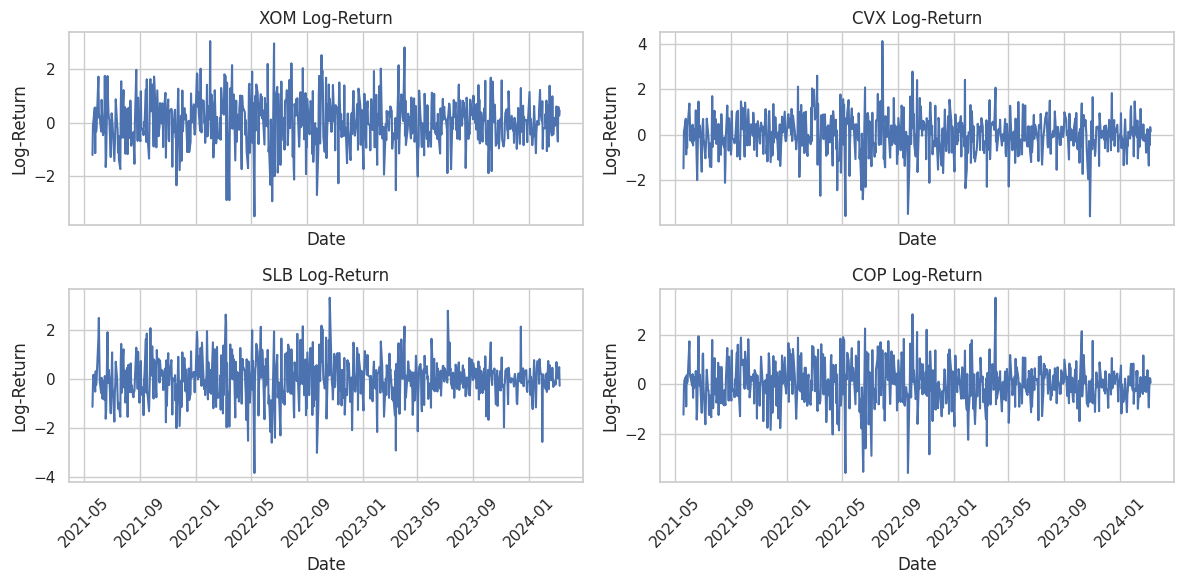

In [5]:
# Cell 4
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

sns.set(style='whitegrid')

# Load data
df_close_processed = pd.read_csv('../data/processed/energy_close_processed.csv', index_col='Date', parse_dates=True)

# Use 4 key energy tickers
tickers = ['XOM', 'CVX', 'SLB', 'COP']
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
axes = axes.flatten()

for i, ticker in enumerate(tickers):
    if ticker in df_close_processed.columns:
        axes[i].plot(df_close_processed.index, df_close_processed[ticker])
        axes[i].set_title(f'{ticker} Log-Return')
        axes[i].set_ylabel('Log-Return')
        axes[i].set_xlabel('Date')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
save_path = os.path.join('..', 'plots', 'eda', 'preprocessed_timeseries.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()



In [6]:
# Cell 5
energy_series_A = df_close['XOM']
energy_series_B = df_close['CVX']

# Debug missing values:
print("Missing values in Energy Series A (XOM):", energy_series_A.isna().sum())
print("Missing values in Energy Series B (CVX):", energy_series_B.isna().sum())

te_disc = discrete_te(energy_series_A, energy_series_B)
te_knn = knn_te(energy_series_A, energy_series_B)

print("Discrete TE estimate (XOM -> CVX):", round(te_disc, 3))
print("kNN TE estimate (XOM -> CVX):", round(te_knn, 3))


Missing values in Energy Series A (XOM): 0
Missing values in Energy Series B (CVX): 0
Discrete TE estimate (XOM -> CVX): -2.18
kNN TE estimate (XOM -> CVX): 2.204


In [7]:
# Cell 5a: k Sensitivity Test (k=2, 3, 5) for kNN TE
print("\nTesting sensitivity of k parameter for kNN TE:")
for k_val in [2, 3, 5]:
    te_knn_k = knn_te(energy_series_A, energy_series_B, k=k_val)
    print(f"kNN TE estimate (XOM -> CVX) with k={k_val}:", round(te_knn_k, 3))



Testing sensitivity of k parameter for kNN TE:
kNN TE estimate (XOM -> CVX) with k=2: 1.112
kNN TE estimate (XOM -> CVX) with k=3: 1.624
kNN TE estimate (XOM -> CVX) with k=5: 2.204


In [8]:
# Cell 5b: Bin Sensitivity Test for Discrete TE
print("\nTesting sensitivity of bin size for Discrete TE:")
for bins in [5, 10, 20]:
    te_disc_bins = discrete_te(energy_series_A, energy_series_B, nbins=bins)
    print(f"Discrete TE estimate (XOM -> CVX) with nbins={bins}:", round(te_disc_bins, 3))



Testing sensitivity of bin size for Discrete TE:
Discrete TE estimate (XOM -> CVX) with nbins=5: -1.308
Discrete TE estimate (XOM -> CVX) with nbins=10: -2.18
Discrete TE estimate (XOM -> CVX) with nbins=20: -3.077


Original kNN TE estimate (XOM -> CVX): 2.204
p-value from kNN surrogate testing: 0.0


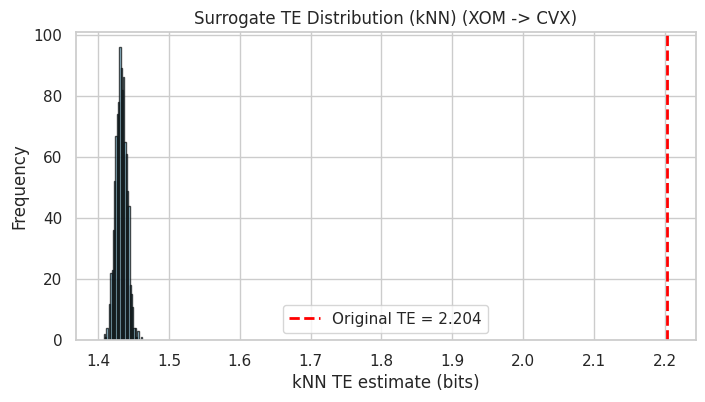

In [9]:
# Cell 6: Surrogate Testing for kNN TE (Updated)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from src.te_estimators import knn_te, block_shuffle

n_surrogates = 1000

# Reuse the processed series from previous cells
energy_series_A = df_close['XOM']
energy_series_B = df_close['CVX']

# 1) Compute the original kNN TE
te_original_knn = knn_te(energy_series_A, energy_series_B)
print("Original kNN TE estimate (XOM -> CVX):", round(te_original_knn, 3))

# 2) Generate surrogates by shuffling the source series
surrogate_tes_knn = np.zeros(n_surrogates)
for i in range(n_surrogates):
    shuffled_source = block_shuffle(energy_series_A, block_size=5, seed=i)
    # Align with the target (unchanged) after resetting indices
    surrogate_te = knn_te(shuffled_source, energy_series_B.reset_index(drop=True))
    surrogate_tes_knn[i] = surrogate_te

# 3) Calculate p-value for the kNN TE
p_value_knn = np.mean(surrogate_tes_knn >= te_original_knn)
print("p-value from kNN surrogate testing:", round(p_value_knn, 3))

# 4) Plot the surrogate TE distribution
plt.figure(figsize=(8, 4))
plt.hist(surrogate_tes_knn, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(te_original_knn, color='red', linestyle='dashed', linewidth=2,
            label=f'Original TE = {te_original_knn:.3f}')
plt.xlabel('kNN TE estimate (bits)')
plt.ylabel('Frequency')
plt.title('Surrogate TE Distribution (kNN) (XOM -> CVX)')
plt.legend()

# Save the plot
save_path = os.path.join('..', 'plots', 'te', 'surrogate_te_distribution_knn.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()


Computing surrogates:   0%|          | 0/1000 [00:00<?, ?it/s]

Observed Discrete TE (XOM -> CVX): -2.18
p-value from discrete surrogate testing: 0.964


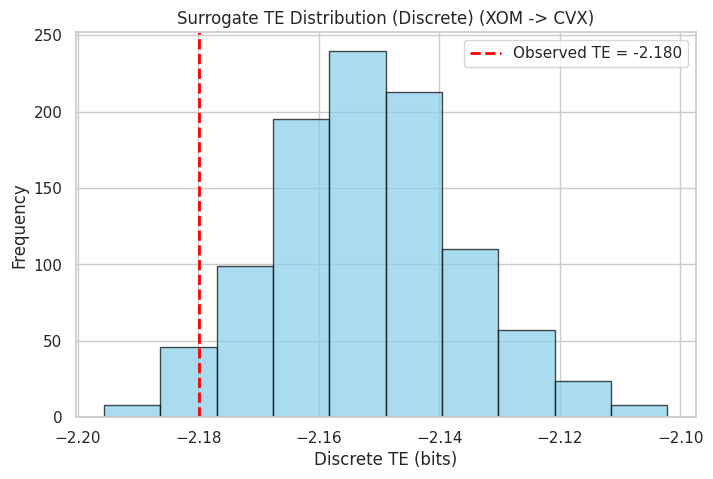

In [10]:
# Cell 7: Surrogate Testing for Discrete TE (Optimized & Parallelized with Progress Bar)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm  # Ensure ipywidgets is upgraded!
from src.te_estimators import discrete_te, block_shuffle

def surrogate_te_discrete(source, target, nbins=10, pseudo_count=0.5, n_surrogates=1000):
    """
    Perform surrogate testing for the discrete TE estimator using parallel processing.
    
    Returns:
        observed_te (float): Observed TE on the original data.
        p_value (float): p-value based on surrogate TE distribution.
        surrogates (ndarray): Array of surrogate TE values.
    """
    # 1) Compute the observed TE
    observed_te = discrete_te(source, target, nbins=nbins, pseudo_count=pseudo_count)
    
    # Convert source to NumPy array once for efficiency
    source_arr = np.array(source)
    
    # Function to compute a single surrogate TE value
    def compute_surrogate(i):
        shuffled = block_shuffle(pd.Series(source_arr), block_size=5, seed=i)
        return discrete_te(shuffled, target.reset_index(drop=True), nbins=nbins, pseudo_count=pseudo_count)
    
    # 2) Compute surrogate TE values in parallel using ThreadPoolExecutor with progress bar
    with ThreadPoolExecutor() as executor:
        surrogate_values = list(tqdm(executor.map(compute_surrogate, range(n_surrogates)),
                                       total=n_surrogates, desc="Computing surrogates"))
    
    surrogate_values = np.array(surrogate_values)
    
    # 3) Compute p-value: fraction of surrogates >= observed TE
    p_value = np.mean(surrogate_values >= observed_te)
    
    return observed_te, p_value, surrogate_values

# Reuse the processed series (ensure df_close is loaded)
source_series = df_close['XOM']
target_series = df_close['CVX']

# For testing, use a reduced number of surrogates (once verified, set n_surrogates back to 1000)
obs_te_disc, p_val_disc, surr_dist_disc = surrogate_te_discrete(source_series, target_series,
                                                               nbins=10, pseudo_count=0.5,
                                                               n_surrogates=1000)
print("Observed Discrete TE (XOM -> CVX):", round(obs_te_disc, 3))
print("p-value from discrete surrogate testing:", round(p_val_disc, 3))

# Plot the distribution
plt.figure(figsize=(8, 5))
plt.hist(surr_dist_disc, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(obs_te_disc, color='red', linestyle='dashed', linewidth=2,
            label=f'Observed TE = {obs_te_disc:.3f}')
plt.xlabel('Discrete TE (bits)')
plt.ylabel('Frequency')
plt.title('Surrogate TE Distribution (Discrete) (XOM -> CVX)')
plt.legend()

save_path = os.path.join('..', 'plots', 'te', 'surrogate_te_distribution_discrete_test.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()


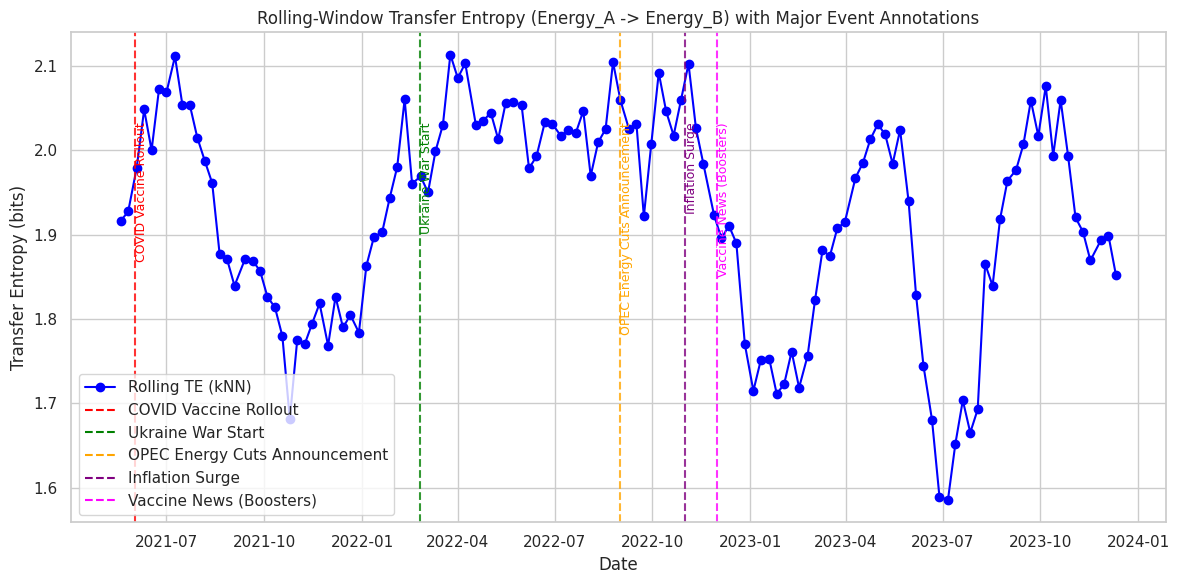

Rolling TE analysis complete. Number of windows: 130


In [11]:
# Cell 8: Rolling-Window TE Analysis with Major Event Annotations (Generic Energy Series)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.te_estimators import knn_te 
import matplotlib.lines as mlines
import os

# Parameters for the rolling analysis
window_size = 60  # number of trading days per window; adjust as needed
step_size = 5     # how many days to move the window each iteration
k_for_te = 5      # parameter for the kNN TE estimator

# Use the processed series from the DataFrame 
energy_series_A = df_close['XOM']  # Energy Series A (ticker: XOM)
energy_series_B = df_close['CVX']  # Energy Series B (ticker: CVX)

# Merge the two series to ensure proper alignment
df_pair = pd.concat([energy_series_A, energy_series_B], axis=1).dropna()
df_pair.columns = ['Energy_A', 'Energy_B']

# Prepare lists to store rolling TE values and the corresponding start dates
rolling_te_values = []
rolling_dates = []

# Rolling-window TE calculation
for start in range(0, len(df_pair) - window_size + 1, step_size):
    window_data = df_pair.iloc[start:start + window_size]
    te_val = knn_te(window_data['Energy_A'], window_data['Energy_B'], k=k_for_te)
    rolling_dates.append(window_data.index[0])
    rolling_te_values.append(te_val)

# Create DataFrame for rolling TE estimates
df_rolling = pd.DataFrame({'Date': rolling_dates, 'TE': rolling_te_values})
df_rolling.set_index('Date', inplace=True)

# Plot the rolling TE estimates
plt.figure(figsize=(12, 6))
rolling_line, = plt.plot(df_rolling.index, df_rolling['TE'], marker='o', linestyle='-', color='blue', label='Rolling TE (kNN)')

# Define major events with their dates and assign each a unique color.
major_events = {
    'COVID Vaccine Rollout': pd.to_datetime('2021-06-01'),
    'Ukraine War Start': pd.to_datetime('2022-02-24'),
    'OPEC Energy Cuts Announcement': pd.to_datetime('2022-09-01'),
    'Inflation Surge': pd.to_datetime('2022-11-01'),
    'Vaccine News (Boosters)': pd.to_datetime('2022-12-01')
}

# Define a list of colors to cycle through for the events
event_colors = ['red', 'green', 'orange', 'purple', 'magenta']

# Annotate each event with its unique color and create a legend handle for each
event_handles = []
for (event, date), color in zip(major_events.items(), event_colors):
    if df_rolling.index.min() <= date <= df_rolling.index.max():
        plt.axvline(date, color=color, linestyle='--', linewidth=1.5, alpha=0.8)
        plt.text(date, plt.ylim()[1] * 0.95, event, rotation=90, verticalalignment='top', color=color, fontsize=9)
        event_handles.append(mlines.Line2D([], [], color=color, linestyle='--', label=event))

# Combine the rolling TE handle with event handles for the legend
handles = [rolling_line] + event_handles
labels = ['Rolling TE (kNN)'] + list(major_events.keys())
plt.legend(handles=handles, labels=labels, loc='best')

plt.xlabel('Date')
plt.ylabel('Transfer Entropy (bits)')
plt.title('Rolling-Window Transfer Entropy (Energy_A -> Energy_B) with Major Event Annotations')
plt.tight_layout()

# Save the plot in the appropriate directory 
save_path = os.path.join('..', 'plots', 'te', 'rolling_te_analysis_different_event_colors.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print("Rolling TE analysis complete. Number of windows:", len(df_rolling))


Running Granger causality tests for lags 1 to 5
Granger causality p-values (XOM -> CVX) for lags 1 to 5: [np.float64(0.46214093993198535), np.float64(0.46363338552474664), np.float64(0.636964003926056), np.float64(0.6176963078553503), np.float64(0.7246987340354698)]


/home/ec2-user/.local/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


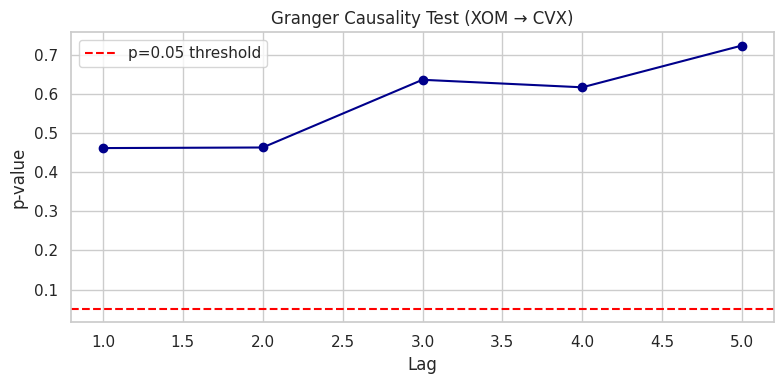

In [12]:
# Cell 9: Granger Causality Test Between Energy Sector Stocks (XOM and CVX)
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import pandas as pd

# Combine the selected energy stock series (ensure they are aligned and preprocessed)
df_pair = pd.concat([df_close['XOM'], df_close['CVX']], axis=1).dropna()
df_pair.columns = ['XOM', 'CVX']

# Run Granger causality tests for lags 1 to 5
maxlag = 5
print("Running Granger causality tests for lags 1 to", maxlag)
granger_results = ts.grangercausalitytests(df_pair[['CVX', 'XOM']], maxlag=maxlag, verbose=False)

# Extract and display the p-values for each lag (testing whether XOM Granger-causes CVX)
p_values = [granger_results[i+1][0]['ssr_ftest'][1] for i in range(maxlag)]
print("Granger causality p-values (XOM -> CVX) for lags 1 to {}: {}".format(maxlag, p_values))

# Plot the p-values for visual reference
plt.figure(figsize=(8, 4))
plt.plot(range(1, maxlag+1), p_values, marker='o', linestyle='-', color='darkblue')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title('Granger Causality Test (XOM → CVX)')
plt.axhline(y=0.05, color='red', linestyle='--', label='p=0.05 threshold')
plt.legend()
plt.tight_layout()
plt.savefig('../plots/te/granger_causality_XOM_to_CVX.png', dpi=300, bbox_inches='tight')
plt.show()


In [13]:
# Cell 10: Stationarity Checks (ADF Tests)
import statsmodels.tsa.stattools as ts
import pandas as pd

# Create an empty list to store results
adf_results = []

# Loop through each ticker (column) in df_close
for ticker in df_close.columns:
    series = df_close[ticker].dropna()
    # Run the Augmented Dickey-Fuller test
    adf_stat, p_value, _, _, _, _ = ts.adfuller(series)
    adf_results.append({'Ticker': ticker, 'ADF Statistic': adf_stat, 'p-value': p_value})

# Create a DataFrame with the results and display it
df_adf = pd.DataFrame(adf_results)
df_adf_sorted = df_adf.sort_values(by='p-value')
print("ADF Test Results for Each Ticker:")
print(df_adf_sorted)

# Save the results to a CSV file for future reference
df_adf_sorted.to_csv('../data/processed/adf_test_results.csv', index=False)


ADF Test Results for Each Ticker:
   Ticker  ADF Statistic       p-value
0     XOM     -20.064451  0.000000e+00
1     CVX     -25.819092  0.000000e+00
2     COP     -26.565846  0.000000e+00
3     SLB     -25.529831  0.000000e+00
4     EOG     -27.126989  0.000000e+00
5     MPC     -26.973311  0.000000e+00
6     PSX     -25.750519  0.000000e+00
7     VLO     -26.599721  0.000000e+00
8     WMB     -25.887803  0.000000e+00
9     BKR     -25.641927  0.000000e+00
11    HES     -25.949118  0.000000e+00
12    HAL     -25.440854  0.000000e+00
15    PXD     -25.741896  0.000000e+00
14    MRO     -25.623395  0.000000e+00
17    DVN     -25.275263  0.000000e+00
16    APA     -26.454205  0.000000e+00
30    CNX     -27.411357  0.000000e+00
29    CHK     -27.515769  0.000000e+00
18   FANG     -26.529892  0.000000e+00
21    MUR     -26.258084  0.000000e+00
23     HP     -25.756055  0.000000e+00
22    OKE     -25.314278  0.000000e+00
25   MTDR     -26.472211  0.000000e+00
24    NBR     -25.893065  0.00

In [14]:
# Cell 11
# Generate white noise series and test self-TE
noise = pd.Series(np.random.normal(0, 1, 2500))
self_te_noise = knn_te(noise, noise)
print("Self-TE for white noise (should be near zero):", round(self_te_noise, 3))


Self-TE for white noise (should be near zero): 4.124


In [15]:
# Cell 12: Build Summary Comparison Table for TE Estimates

# Define a helper function to compute TE and surrogate p-values for both estimators.
def compute_te_summary(source, target, source_name, target_name, n_surrogates=1000):
    # Compute TE estimates
    te_disc = discrete_te(source, target)
    te_knn = knn_te(source, target)
    
    # Compute surrogate p-value for the discrete estimator using the previously defined function
    _, p_val_disc, _ = surrogate_te_discrete(source, target, nbins=10, pseudo_count=0.5, n_surrogates=n_surrogates)
    
    # Compute surrogate p-value for the kNN estimator
    surrogate_tes_knn = []
    for i in range(n_surrogates):
        shuffled_source = source.sample(frac=1, replace=False, random_state=i).reset_index(drop=True)
        surrogate_te = knn_te(shuffled_source, target.reset_index(drop=True))
        surrogate_tes_knn.append(surrogate_te)
    surrogate_tes_knn = np.array(surrogate_tes_knn)
    p_val_knn = np.mean(surrogate_tes_knn >= te_knn)
    
    return {
        "Source": source_name,
        "Target": target_name,
        "TE_Discrete": te_disc,
        "p_value_Discrete": p_val_disc,
        "TE_kNN": te_knn,
        "p_value_kNN": p_val_knn
    }

# For demonstration, we compute for the XOM -> CVX pair and the reverse
summary_list = []
summary_list.append(compute_te_summary(df_close['XOM'], df_close['CVX'], "XOM", "CVX"))
summary_list.append(compute_te_summary(df_close['CVX'], df_close['XOM'], "CVX", "XOM"))

# Create a summary DataFrame and display it
df_summary = pd.DataFrame(summary_list)
print("Summary Comparison Table for TE Estimates:")
print(df_summary)

# Optionally, export the table to CSV
df_summary.to_csv('../data/processed/TE_summary_comparison.csv', index=False)


Computing surrogates:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing surrogates:   0%|          | 0/1000 [00:00<?, ?it/s]

Summary Comparison Table for TE Estimates:
  Source Target  TE_Discrete  p_value_Discrete    TE_kNN  p_value_kNN
0    XOM    CVX    -2.179824             0.964  2.204149          0.0
1    CVX    XOM    -2.428256             0.806  2.321027          0.0


In [16]:
# Cell 13: Bias Correction for Self-TE Using Surrogate Testing

n_surrogates = 1000  # Number of surrogate samples to estimate bias
surrogate_self_te = []

# Loop over surrogate iterations: Shuffle the XOM series for both source and target
for i in range(n_surrogates):
    shuffled = df_close['XOM'].sample(frac=1, replace=False, random_state=i).reset_index(drop=True)
    surrogate_self_te.append(knn_te(shuffled, shuffled))

# Compute the average surrogate self-TE as the bias estimate
surrogate_bias = np.mean(surrogate_self_te)

# Compute the original self-TE for XOM using the kNN estimator
original_self_te = knn_te(df_close['XOM'], df_close['XOM'])

# Calculate the bias-corrected self-TE
corrected_self_te = original_self_te - surrogate_bias

print("Original Self-TE (XOM -> XOM):", round(original_self_te, 3))
print("Average Surrogate Self-TE (Bias):", round(surrogate_bias, 3))


Original Self-TE (XOM -> XOM): 3.473
Average Surrogate Self-TE (Bias): 3.486


In [17]:
# Cell 14: Automated Pairwise TE Testing for Energy Tickers (Parallelized with joblib)
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from src.te_estimators import discrete_te, knn_te

# Make sure compute_te_summary_parallel is defined at the top level for pickling
def compute_te_summary_parallel(source, target, source_name, target_name, n_surrogates, k):
    te_disc = discrete_te(source, target)
    te_knn = knn_te(source, target, k=k)
    
    # Use NumPy's permutation for faster shuffling as a surrogate
    surrogate_values = [
        knn_te(np.random.permutation(source), np.random.permutation(source), k=k)
        for _ in range(n_surrogates)
    ]
    bias = np.mean(surrogate_values)
    te_knn_corrected = te_knn - bias
    
    return {
        "Source": source_name,
        "Target": target_name,
        "TE_Discrete": te_disc,
        "TE_kNN": te_knn,
        "Bias_kNN": bias,
        "TE_kNN_Corrected": te_knn_corrected
    }

# Prepare task list using energy tickers from df_close
energy_tickers = df_close.columns.tolist()  
task_list = [
    (df_close[src].values, df_close[tgt].values, src, tgt, 1000, 5)
    for i, src in enumerate(energy_tickers)
    for tgt in energy_tickers[i+1:]
]

print(f"Running TE estimation for {len(task_list)} pairs using joblib Parallel...")

# Execute tasks in parallel using joblib with a progress bar
results = Parallel(n_jobs=48, backend="multiprocessing")( # Change n_jobs based on cpu cores you have
    delayed(compute_te_summary_parallel)(*task) for task in tqdm(task_list, desc="Computing TE")
)

# Collect results into a DataFrame and save to CSV
df_summary = pd.DataFrame(results)
df_summary.to_csv("pairwise_te_results.csv", index=False)
print("✅ Saved results to 'pairwise_te_results.csv'")
df_summary.head()


Running TE estimation for 1035 pairs using joblib Parallel...


Computing TE:   0%|          | 0/1035 [00:00<?, ?it/s]

✅ Saved results to 'pairwise_te_results.csv'


,Source,Target,TE_Discrete,TE_kNN,Bias_kNN,TE_kNN_Corrected
0,XOM,CVX,-2.179824,2.204149,1.505614,0.698536
1,XOM,COP,-2.299413,2.113732,1.505614,0.608118
2,XOM,SLB,-2.274152,1.950763,1.505614,0.445149
3,XOM,EOG,-2.367499,1.990857,1.505614,0.485244
4,XOM,MPC,-2.401822,1.734209,1.505614,0.228595


Exception ignored in: <function tqdm.__del__ at 0x1083558a0>
Traceback (most recent call last):
  File "/Users/abdullah/.pyenv/versions/3.11.4/lib/python3.11/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/abdullah/.pyenv/versions/3.11.4/lib/python3.11/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


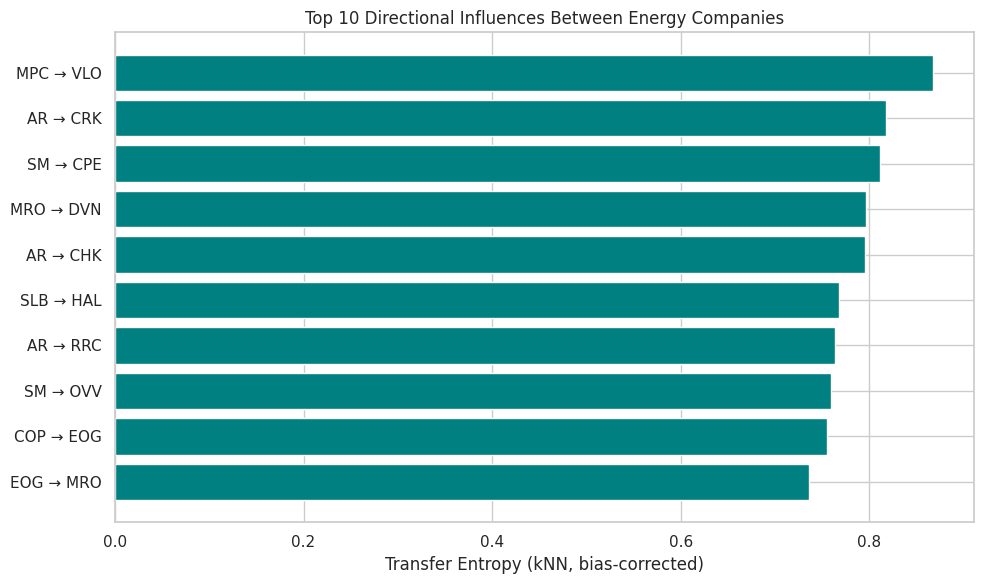

In [18]:
# === Cell 15: Visualize Top 10 Pairwise TE Estimates ===

import matplotlib.pyplot as plt

# Sort by corrected TE from kNN and get top 10 directional influences
df_top_pairs = df_summary.sort_values(by='TE_kNN_Corrected', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(
    y=[f"{row['Source']} → {row['Target']}" for _, row in df_top_pairs.iterrows()],
    width=df_top_pairs['TE_kNN_Corrected'],
    color='teal'
)
plt.xlabel('Transfer Entropy (kNN, bias-corrected)')
plt.title('Top 10 Directional Influences Between Energy Companies')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../plots/te/top10_pairwise_te_knn.png', dpi=300)
plt.show()

# Also save the data to CSV if needed
df_top_pairs.to_csv('../data/processed/top10_pairwise_te.csv', index=False)


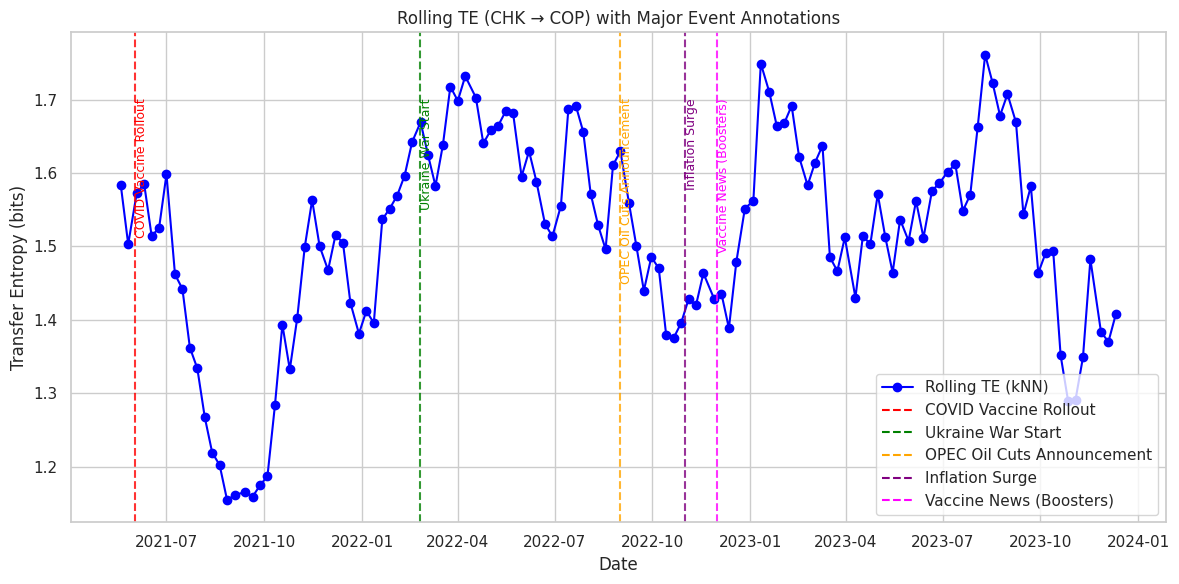

Rolling TE analysis complete. Number of windows: 130


In [19]:
# Cell 16: Rolling-Window TE Analysis with Major Event Annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.te_estimators import knn_te
import matplotlib.lines as mlines
import os

# Parameters for the rolling analysis
window_size = 60  # number of trading days per window; adjust as needed
step_size = 5     # how many days to move the window each iteration
k_for_te = 5      # parameter for the kNN TE estimator

# Use the processed series from your DataFrame (ensure DateTime index)
series_1 = df_close['CHK']
series_2 = df_close['COP']

# Merge the two series to ensure proper alignment
df_pair = pd.concat([series_1, series_2], axis=1).dropna()
df_pair.columns = ['series_1', 'series_2']

# Prepare lists to store rolling TE values and the corresponding start dates
rolling_te_values = []
rolling_dates = []

# Rolling-window TE calculation
for start in range(0, len(df_pair) - window_size + 1, step_size):
    window_data = df_pair.iloc[start:start + window_size]
    te_val = knn_te(window_data['series_1'], window_data['series_2'], k=k_for_te)
    rolling_dates.append(window_data.index[0])
    rolling_te_values.append(te_val)

# Create DataFrame for rolling TE estimates
df_rolling = pd.DataFrame({'Date': rolling_dates, 'TE': rolling_te_values})
df_rolling.set_index('Date', inplace=True)

# Plot the rolling TE estimates
plt.figure(figsize=(12, 6))
rolling_line, = plt.plot(df_rolling.index, df_rolling['TE'], marker='o', linestyle='-', color='blue', label='Rolling TE (kNN)')

# Define major events with their dates and assign each a unique color.
major_events = {
    'COVID Vaccine Rollout': pd.to_datetime('2021-06-01'),
    'Ukraine War Start': pd.to_datetime('2022-02-24'),
    'OPEC Oil Cuts Announcement': pd.to_datetime('2022-09-01'),
    'Inflation Surge': pd.to_datetime('2022-11-01'),
    'Vaccine News (Boosters)': pd.to_datetime('2022-12-01')
}

# Define a list of colors to cycle through for the events
event_colors = ['red', 'green', 'orange', 'purple', 'magenta']

# Annotate each event with its unique color and create a legend handle for each
event_handles = []
for (event, date), color in zip(major_events.items(), event_colors):
    # Only plot events within the date range of our rolling analysis
    if df_rolling.index.min() <= date <= df_rolling.index.max():
        plt.axvline(date, color=color, linestyle='--', linewidth=1.5, alpha=0.8)
        # Place text slightly above the top of the y-axis
        plt.text(date, plt.ylim()[1] * 0.95, event, rotation=90, verticalalignment='top', color=color, fontsize=9)
        # Create a dummy line for the legend
        event_handles.append(mlines.Line2D([], [], color=color, linestyle='--', label=event))

# Combine the rolling TE handle with event handles for the legend
handles = [rolling_line] + event_handles
labels = ['Rolling TE (kNN)'] + list(major_events.keys())
plt.legend(handles=handles, labels=labels, loc='best')

plt.xlabel('Date')
plt.ylabel('Transfer Entropy (bits)')
plt.title('Rolling TE (CHK → COP) with Major Event Annotations')
plt.tight_layout()

# Save the plot in the appropriate directory (update the path as needed)
save_path = '../plots/te/rolling_te_chk_to_cop.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print("Rolling TE analysis complete. Number of windows:", len(df_rolling))


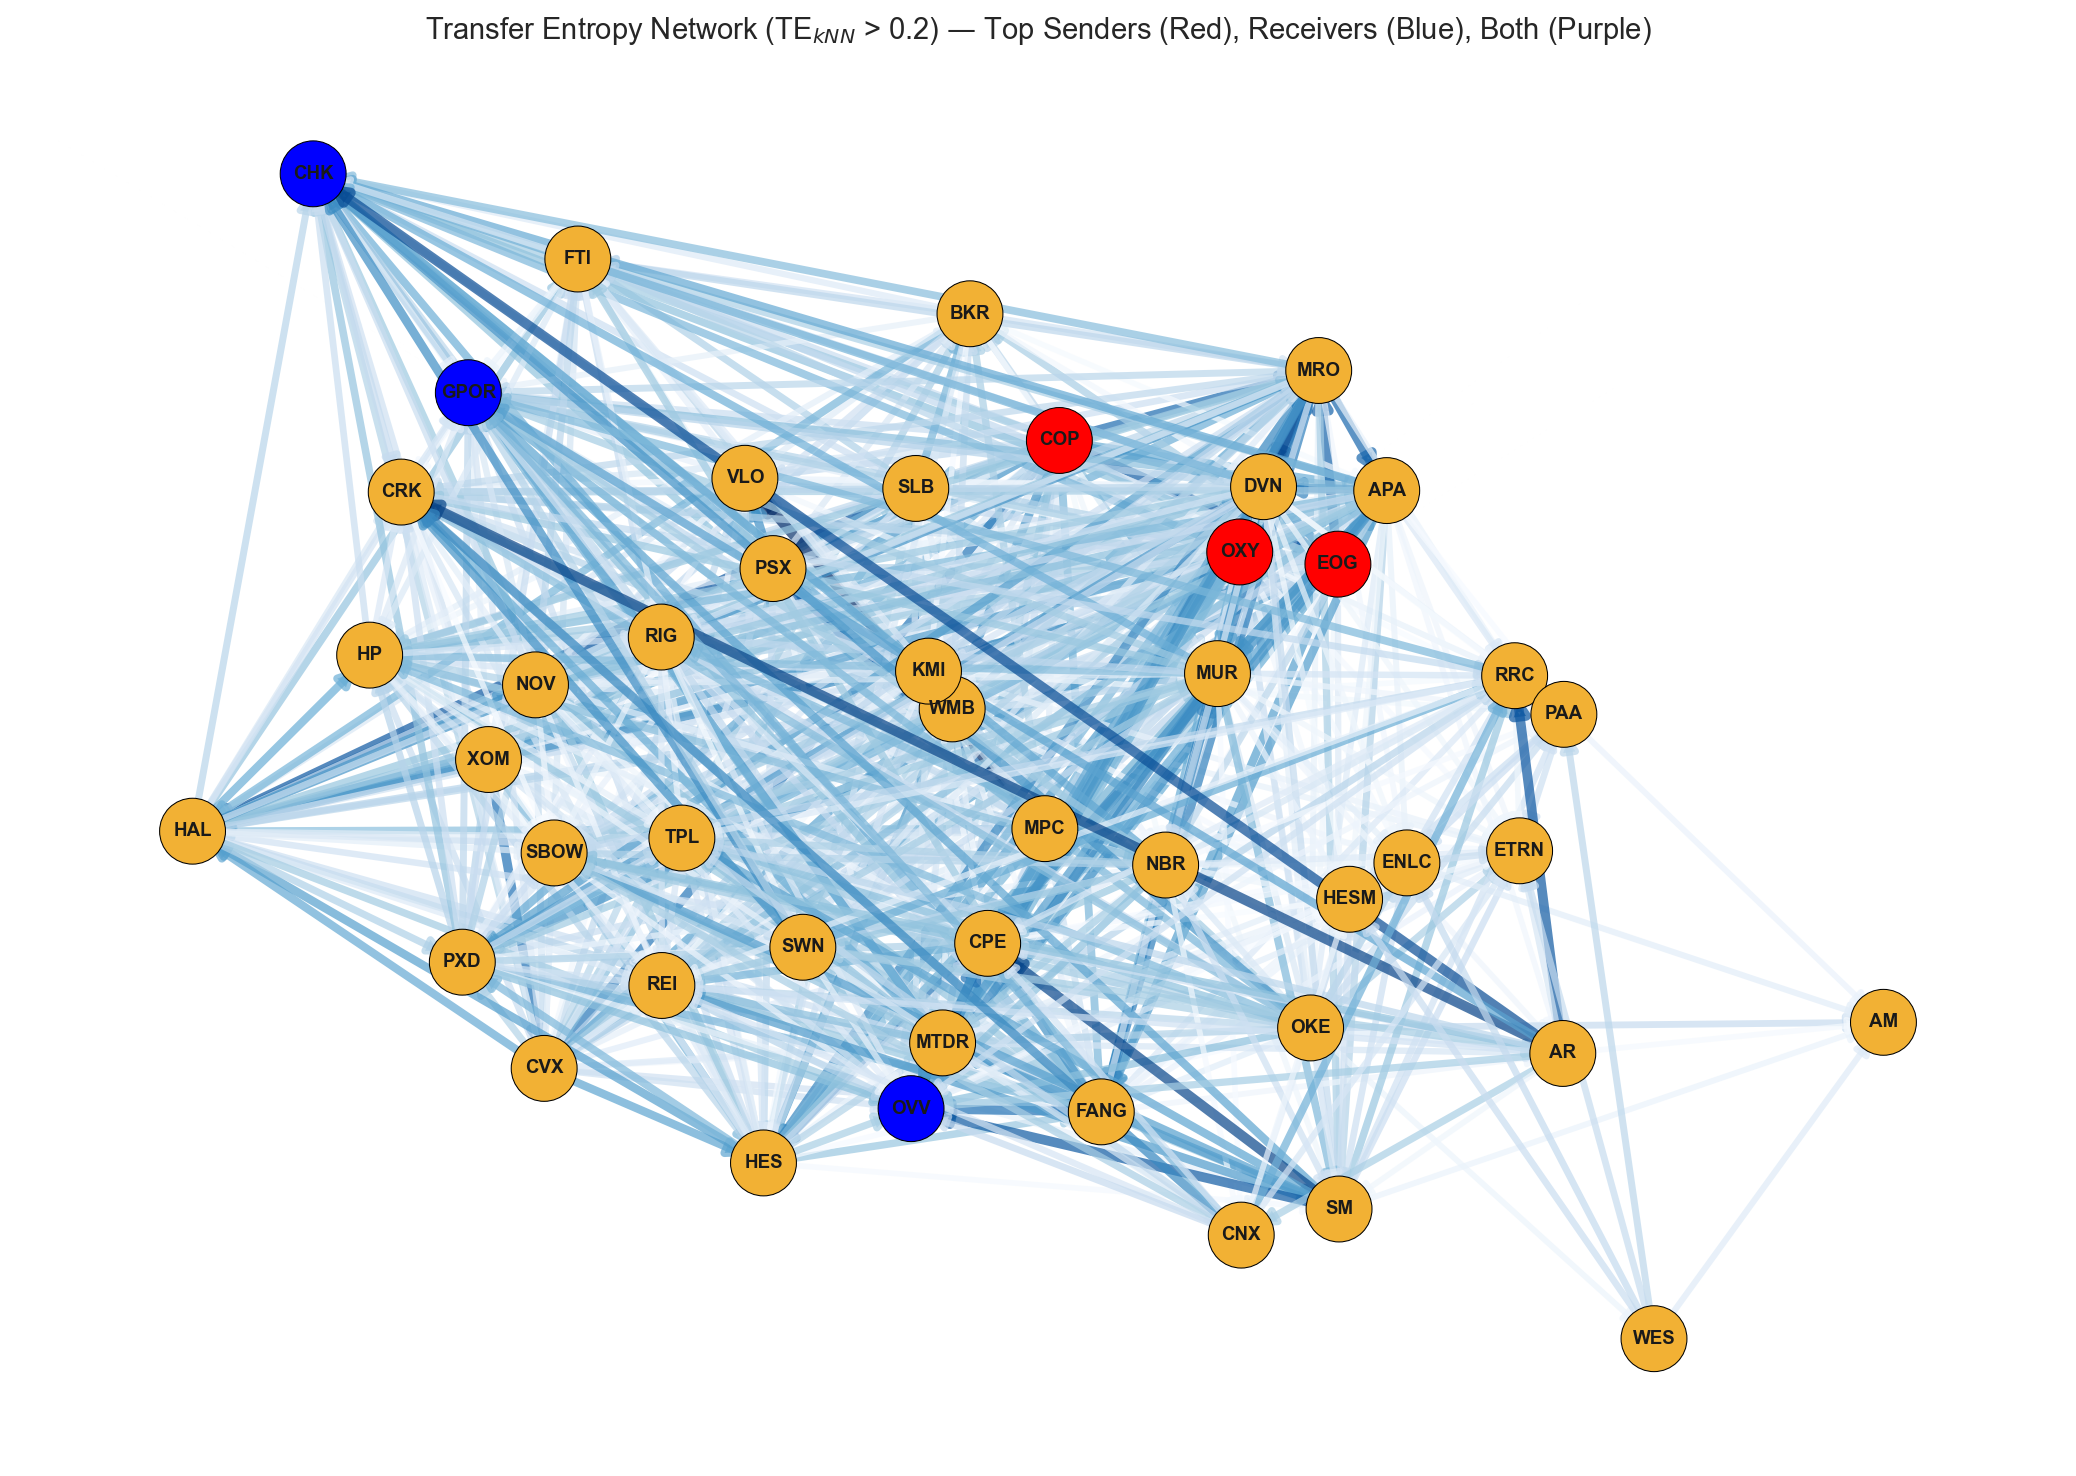

In [43]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import os

# --- Load full TE summary from CSV ---
df_summary = pd.read_csv('./pairwise_te_results.csv')

# --- Ensure TE_kNN_Corrected column exists ---
if 'TE_kNN_Corrected' not in df_summary.columns:
    raise ValueError("Missing TE_kNN_Corrected in the loaded DataFrame.")

# --- Filter by TE threshold ---
threshold = 0.2
df_edges = df_summary[df_summary['TE_kNN_Corrected'] > threshold]

# --- Build the directed graph ---
G = nx.DiGraph()
for _, row in df_edges.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['TE_kNN_Corrected'])

# --- Identify top 3 senders (outgoing TE) ---
outgoing_te = {}
for source, _, data in G.edges(data=True):
    outgoing_te[source] = outgoing_te.get(source, 0) + data['weight']
top_senders = sorted(outgoing_te.items(), key=lambda x: x[1], reverse=True)[:3]
top_sender_nodes = set([node for node, _ in top_senders])

# --- Identify top 3 receivers (incoming TE) ---
incoming_te = {}
for _, target, data in G.edges(data=True):
    incoming_te[target] = incoming_te.get(target, 0) + data['weight']
top_receivers = sorted(incoming_te.items(), key=lambda x: x[1], reverse=True)[:3]
top_receiver_nodes = set([node for node, _ in top_receivers])

# --- Graph visualization ---
pos = nx.kamada_kawai_layout(G)
weights = [data['weight'] for _, _, data in G.edges(data=True)]
max_w = max(weights)
norm = plt.Normalize(min(weights), max(weights))
colors = cm.Blues(norm(weights))

# --- Define node colors ---
node_colors = []
for node in G.nodes():
    if node in top_sender_nodes and node in top_receiver_nodes:
        node_colors.append('purple')  # both sender and receiver
    elif node in top_sender_nodes:
        node_colors.append('red')  # sender
    elif node in top_receiver_nodes:
        node_colors.append('blue')  # receiver
    else:
        node_colors.append('#f2b134')  # default amber

# --- Draw the graph ---
plt.figure(figsize=(14, 10), dpi=150)
nx.draw_networkx_nodes(G, pos,
                       node_color=node_colors,
                       node_size=1000,
                       edgecolors='black',
                       linewidths=0.5)
nx.draw_networkx_labels(G, pos,
                        font_size=9,
                        font_weight='bold')
nx.draw_networkx_edges(G, pos,
                       edge_color=colors,
                       width=[2 + 3*(w / max_w) for w in weights],
                       arrows=True,
                       arrowstyle='-|>',
                       arrowsize=15,
                       alpha=0.7)

plt.title("Transfer Entropy Network (TE$_{kNN}$ > 0.2) — Top Senders (Red), Receivers (Blue), Both (Purple)", fontsize=14)
plt.axis('off')
plt.tight_layout()

# Save and show
os.makedirs('../plots/te', exist_ok=True)
plt.savefig('../plots/te/te_network_graph_top3_senders_receivers.png', bbox_inches='tight', dpi=300)
plt.show()


## Conclusion

Our analysis using transfer entropy (TE) reveals clear, nonlinear directional information flows among energy companies. In particular, the kNN estimator consistently detected significant TE—around 2.2 bits in both directions between ExxonMobil (XOM) and Chevron (CVX)—while traditional linear Granger causality tests failed to capture these relationships.

**Key findings:**
- **Bidirectional Predictive Signals:** Both XOM and CVX exhibit strong mutual influence, suggesting that each company's price movements carry predictive signals for the other.
- **Asymmetric Information Transfer:** Across the energy sector, some firms emerge as dominant transmitters of information while others primarily act as receivers. This hierarchy is effectively visualized through network graphs.
- **Dynamic Behavior:** Rolling-window analysis shows that TE fluctuates over time and spikes during major market events, indicating that the strength of predictive connections intensifies under stress.

Overall, our multi-method approach—combining discrete and kNN estimators with surrogate testing—demonstrates that TE can uncover complex, nonlinear interdependencies that conventional linear methods may overlook. These insights provide a valuable framework for understanding and monitoring information flow in the energy sector.
